# DU-ISTA法 

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [17]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 準備 (グローバル定数の設定)

In [18]:
n = 128
m = 64
σ = 0.1
p = 0.05
num_itr = 40

K = 200
adam_lr = 5e-5
max_inner = 20

A = randn(m, n)
γ_opt = 1.0/maximum(eigvals(A'*A))

0.0026879399247698083

### ミニバッチ生成関数 (スパースベクトル生成関数)

In [19]:
function mini_batch(K)
    seq = randn(n,K)
    support = zeros(n, K)
    for i in 1:n
        for j in 1:K
            if rand() < p
                support[i,j] = 1
            end
        end
    end
    x = seq .* support
    y = A*x + σ*randn(m,K)
    return y, x
end

mini_batch (generic function with 1 method)

In [20]:
@time y, xorg = mini_batch(K)

  0.036752 seconds (45.78 k allocations: 2.413 MiB, 96.39% compilation time)


([-1.0636073552517329 -0.09559815122290788 … 3.3873046691776545 3.8467863263414874; -3.6268880992099644 0.6418606181613433 … 0.11455488474585084 8.811635826671024; … ; 1.2059202700273723 0.6718688701194104 … 0.6694815776972631 0.6400070620953586; 3.875253743547058 0.3093998423761087 … 0.6189456002995832 -1.110705342811185], [0.0 -0.0 … -0.0 0.0; -1.015192115084283 0.0 … 0.0 -0.0; … ; 0.0 -0.0 … 0.0 -0.0; 0.0 0.0 … -0.0 0.0])

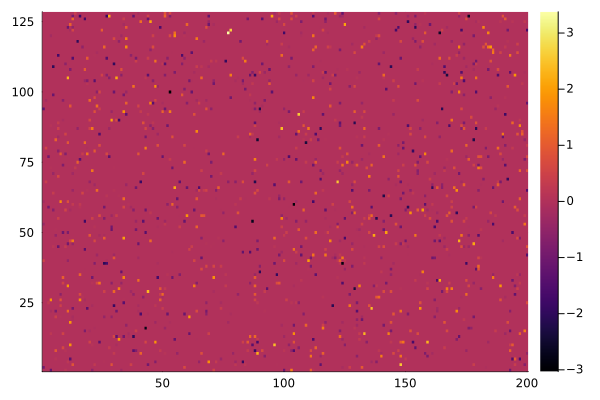

In [21]:
heatmap(xorg)

### ISTA

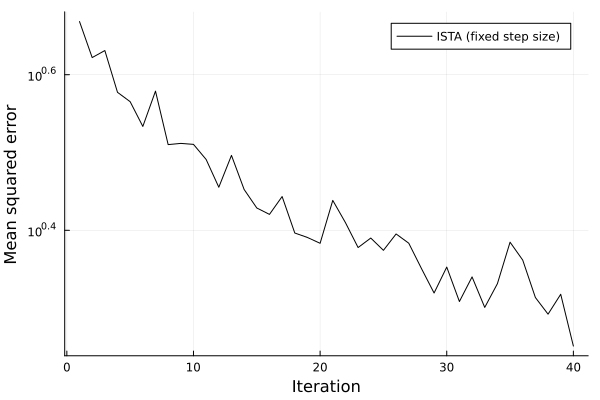

In [22]:
S(x,τ) = sign(x)*max(abs(x)-τ,0)

function ISTA(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - γ_opt*A'*(A*x - y)
        x = S.(x, γ_opt)
    end
    return x
end

function comp_mse(max_itr)
    y, x_org = mini_batch(K)
    x̂ = ISTA(max_itr, y)
    return norm(x_org - x̂)^2/K
end
        
ISTA_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, ISTA_mse, lw=1, yscale=:log10, label="ISTA (fixed step size)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-ISTA反復の定義 

In [23]:
function DU_ISTA(max_itr, y, eta, mu)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - eta[i]*A'*(A*x - y)
        x = S.(x, mu[i])
    end
    return x
end

DU_ISTA (generic function with 1 method)

### 損失関数の定義

In [24]:
function loss(x_org, x̂)
    return norm(x_org - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [25]:
function train(opt, eta, mu)
    ps = Flux.params(eta, mu) 
    for itr in 1:num_itr 
        for i in 1:max_inner 
            y, x_org = mini_batch(K)
            gs = Flux.gradient(ps) do
                x_hat = DU_ISTA(itr, y, eta, mu)
                loss(x_org, x_hat)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        y, x_org = mini_batch(K)
        x̂ = DU_ISTA(itr, y, eta, mu)
        println(itr, " ", loss(x_org, x̂))
    end
end

train (generic function with 1 method)

### DU-GDのMSE評価用関数

In [26]:
function comp_mse_DUGD(max_itr, eta, mu)
    y, x_org = mini_batch(K)
    x̂ = DU_ISTA(max_itr, y, eta, mu)
    return loss(x_org, x̂)
end

comp_mse_DUGD (generic function with 1 method)

### 学習過程

1 4.373120095329635
2 3.746520580692445
3 3.6215532583216894
4 3.3033951285114114
5 3.3620308844723907
6 2.7077713282278393
7 2.7324583239489346
8 2.420972855965271
9 2.2421866279360416
10 2.129027353147463
11 1.9551487788937616
12 1.9289327575435014
13 1.582669993490309
14 1.3034872731515008
15 1.316081622417284
16 1.2828482729579227
17 1.1249265819489036
18 0.8990488481620065
19 0.8595188153871078
20 0.7062328920267946
21 0.6321874022786406
22 0.5586976354783999
23 0.6003860412431439
24 0.4788144854742567
25 0.39029313159414686
26 0.4045069060251595
27 0.29187852420454913
28 0.30727581001030696
29 0.2669927870754568
30 0.21655229031731846
31 0.19844007480145323
32 0.17228599951010307
33 0.1411488170276674
34 0.16128257741335641
35 0.13696496703404024
36 0.12123177187486801
37 0.10124916012542101
38 0.12382788857184232
39 0.09432835564700084
40 0.11663920514628058


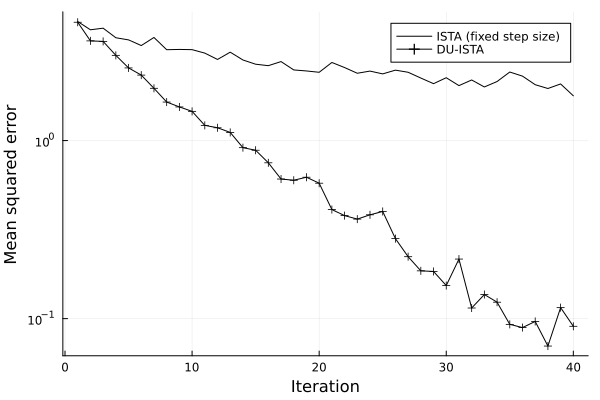

In [27]:
eta_train = γ_opt*ones(num_itr)
mu_train = γ_opt*ones(num_itr)
opt = Flux.ADAM(adam_lr)
train(opt, eta_train, mu_train)
DUGD_mse =[comp_mse_DUGD(i, eta_train, mu_train) for i in 1:num_itr]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-ISTA", color=:black, marker=:+)

In [28]:
savefig("DU-ISTA.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_4/DU-ISTA.pdf"

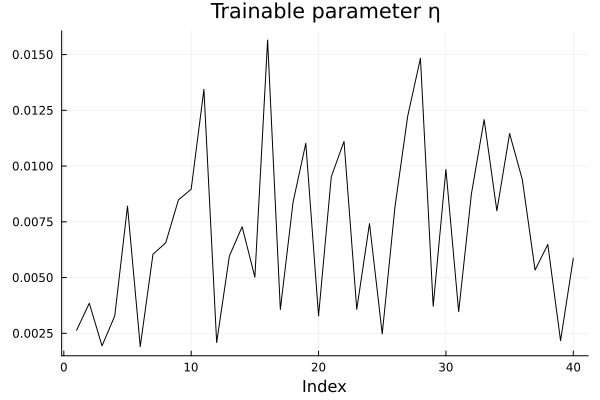

In [29]:
p1 = plot(1:num_itr, eta_train, xlabel="Index", color=:black, legend=false, title="Trainable parameter η")

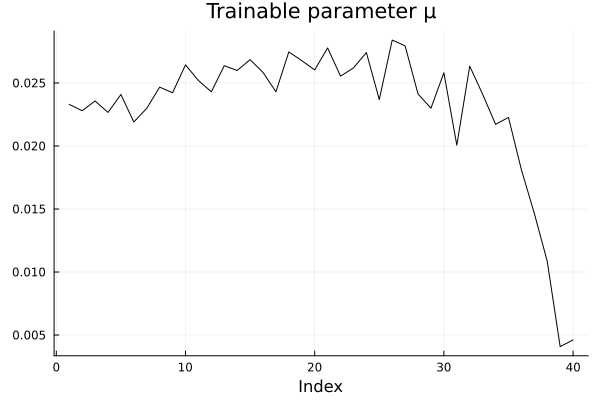

In [30]:
p2 = plot(1:num_itr, mu_train, xlabel="Index", color=:black, legend=false, title="Trainable parameter μ")

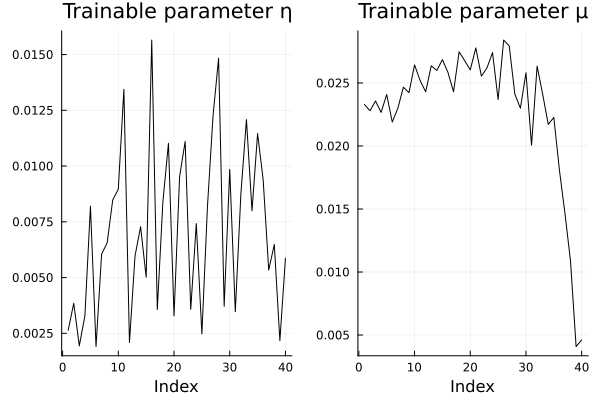

In [31]:
plot(p1,p2)

In [32]:
savefig("DU-ISTA-param.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_4/DU-ISTA-param.pdf"